# Random Forest Rangers - Predicting Car Sales Prices
## Training the models

### Prerequisites

In [1]:
# Install dependencies
# !pip install -q -r requirements.txt

# On MacOS you need the following command
# brew install libomp

In [2]:
import sys
import time

def progress_bar(current, total, start_time, name, bar_width=30):
    """
    Prints a progress bar to the shell.

    Parameters:
    - current (int): Current iteration.
    - total (int): Total number of iterations.
    - start_time (float): Start time of the process (from `time.time()`).
    - name (string): Name of the run.
    - bar_width (int): Width of the progress bar (default: 30).
    """
    elapsed_time = time.time() - start_time
    progress = current / total
    completed = int(bar_width * progress)
    remaining = bar_width - completed
    progress_percent = int(progress * 100)
    est_total_time = elapsed_time / progress if progress > 0 else 0
    est_remaining_time = est_total_time - elapsed_time

    # Create the progress bar
    bar = f"[{'#' * completed}{'-' * remaining}] {progress_percent}%"

    # Display current progress and ETA
    sys.stdout.write(
        f"\r{bar} ({current}/{total}) | Elapsed: {elapsed_time:.2f}s | ETA: {est_remaining_time:.2f}s / {name} "
    )
    sys.stdout.flush()

    # Print a newline when done
    if current == total:
        sys.stdout.write("\n")

In [3]:
# Import neccessary modules
import pandas as pd
import numpy as np

### Load Data

In [4]:
# Load the datasets
train_dataset_original = pd.read_csv('data/1_Preprocessing/train.csv')
print("Training Dataset Original")
print(train_dataset_original.dtypes)
print(train_dataset_original.head(10))
print(50*'-')

train_dataset_mixed = pd.read_csv('data/1_Preprocessing/train_generated_and_original.csv')
print("Training Dataset Mixed")
print(train_dataset_mixed.dtypes)
print(train_dataset_mixed.head(10))
print(50*'-')

test_dataset = pd.read_csv('data/1_Preprocessing/test.csv')
print("Test Dataset")
print(test_dataset.dtypes)
print(test_dataset.head(10))
print(50*'-')

Training Dataset Original
model_year          int64
milage            float64
accident            int64
clean_title         int64
price               int64
horsepower        float64
turbo               int64
is_luxury           int64
is_upper_class      int64
dtype: object
   model_year    milage  accident  clean_title  price  horsepower  turbo  \
0        2000  194277.0         1            1   2300  222.000000      0   
1        2015   13300.0         0            1  62500  449.000000      0   
2        2020   30426.0         1            0  29645  333.666667      0   
3        2020   67072.0         0            1  38500  375.000000      0   
4        2016   99000.0         1            1   5000  172.000000      0   
5        2020   16425.0         1            0  33200  383.000000      0   
6        2013   53900.0         1            0  27450  420.000000      0   
7        2014  146700.0         1            1  24999  270.000000      0   
8        2017   94000.0         0         

In [5]:
# Log transform the target variable
train_dataset_original['price'] = np.log1p(train_dataset_original['price'])
train_dataset_mixed['price'] = np.log1p(train_dataset_mixed['price'])

# Log transform the mileage variable
train_dataset_original['milage'] = np.log1p(train_dataset_original['milage'])
train_dataset_mixed['milage'] = np.log1p(train_dataset_mixed['milage'])

# Log transform for test dataset
test_dataset['milage'] = np.log1p(test_dataset['milage'])
test_dataset['price'] = np.log1p(test_dataset['price'])

### Remove target variable

In [6]:
# Define the features and target variable
X_train_original = train_dataset_original.drop(columns=['price'])
y_train_original = train_dataset_original['price']

X_train_mixed = train_dataset_mixed.drop(columns=['price'])
y_train_mixed = train_dataset_mixed['price']

X_test = test_dataset.drop(columns=['price'])
y_test = test_dataset['price']

In [7]:
y_test.head()

0     9.770013
1     9.852247
2    11.196858
3     9.655090
4    10.819598
Name: price, dtype: float64

In [8]:
def plot_actual_vs_predicted(y_actual, y_predicted, title):
    """
    Plots the actual vs predicted values.

    Parameters:
    - y_actual (array): Actual values.
    - y_predicted (array): Predicted values.
    - title (string): Title of the plot.
    """
    import matplotlib.pyplot as plt

    plt.scatter(y_actual, y_predicted)
    plt.plot([min(y_actual), max(y_actual)], [min(y_actual), max(y_actual)], 'k--', lw=4)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(title)
    plt.show()

In [9]:
def calculate_metrics(y_actual, y_predicted):
    """
    Calculates the evaluation metrics.

    Parameters:
    - y_actual (array): Actual values.
    - y_predicted (array): Predicted values.

    Returns:
    - mse (float): Mean Squared Error.
    - rmse (float): Root Mean Squared Error.
    - mae (float): Mean Absolute Error.
    - mape (float): Mean Absolute Percentage Error.
    """
    from sklearn.metrics import mean_squared_error, mean_absolute_error

    # Undo log transformation
    y_actual = np.expm1(y_actual)
    y_predicted = np.expm1(y_predicted)

    mse = mean_squared_error(y_actual, y_predicted)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_actual, y_predicted)
    mape = np.mean(np.abs((y_actual - y_predicted) / y_actual)) * 100
    r2 = 1 - (np.sum((y_actual - y_predicted) ** 2) / np.sum((y_actual - np.mean(y_actual)) ** 2))
    adj_r2 = 1 - (1 - r2) * ((len(y_actual) - 1) / (len(y_actual) - X_test.shape[1] - 1))
    pcc = np.corrcoef(y_actual, y_predicted)[0, 1]

    return mse, rmse, mae, mape, r2, adj_r2, pcc

In [10]:

from itertools import product
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import RobustScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold

def adjusted_r2(r2, n, p):
    """Calculate Adjusted R²."""
    return 1 - (1 - r2) * ((n - 1) / (n - p - 1))

def hyperparameter_tuning_with_cv(X, y, param_grid, model_class=LinearRegression, n_splits=5, random_state=42, verbose=True, polynomial=False, degree=2, name="Linear Regression"):
    """
    Perform hyperparameter tuning with K-Fold cross-validation.

    Parameters:
    - X (DataFrame or ndarray): Feature matrix.
    - y (Series or ndarray): Target vector.
    - param_grid (dict): Hyperparameter grid as a dictionary of parameter lists.
    - model_class (class): Model class to be instantiated (default: LinearRegression).
    - n_splits (int): Number of splits for K-Fold cross-validation.
    - random_state (int): Random state for reproducibility.
    - verbose (bool): Activate verbose output.
    - polynomial (bool): Whether to apply polynomial feature scaling on the dataset.
    - degree (int): Degree of the polynomial features (default: 2).
    - name (stirng): Name of the run (default: "Linear Regression").

    Returns:
    - dict: Best hyperparameters and performance metrics.
    - list: All results for each hyperparameter combination.
    """
    # Generate all combinations of hyperparameters
    param_combinations = list(product(*param_grid.values()))
    param_array = [dict(zip(param_grid.keys(), combo)) for combo in param_combinations]

    # For tracking the progress in the shell
    total_combinations = len(param_combinations)
    start_time = time.time()

    # Initialize variables to store results
    results = []

    # Scalers and transformers
    scaler = RobustScaler()
    poly_transformer = PolynomialFeatures(degree=degree, include_bias=False) if polynomial else None

    # Iterate over all hyperparameter combinations
    for index, params in enumerate(param_array, start=0):
        if verbose:
            print(f"Testing hyperparameters: {params}")
        else:
            progress_bar(index, total_combinations, start_time, name)

        mae_scores = []
        mape_scores = []
        mse_scores = []
        rmse_scores = []
        adjusted_r2_scores = []
        r2_scores = []
        pcc_scores = []

        # Perform K-Fold cross-validation
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

        for train_index, test_index in kf.split(X):
            # Split the data
            X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
            y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

            # Apply polynomial feature transformation if specified
            if polynomial:
                X_train_fold = poly_transformer.fit_transform(X_train_fold)
                X_test_fold = poly_transformer.transform(X_test_fold)

            # Scale the data
            X_train_fold = scaler.fit_transform(X_train_fold)
            X_test_fold = scaler.transform(X_test_fold)

            # Create a new model for this fold with the current hyperparameters
            model = model_class(**params)

            # Fit the model
            model.fit(X_train_fold, y_train_fold)

            # Predict on the test fold
            y_pred = model.predict(X_test_fold)

            # Calculate metrics
            # mse = mean_squared_error(y_test_fold, y_pred)
            # rmse = np.sqrt(mse)
            # mae = mean_absolute_error(y_test_fold, y_pred)
            # mape = mean_absolute_percentage_error(y_test_fold, y_pred)
            # r2 = max(0, r2_score(y_test_fold, y_pred)) # R² can be negative, make it 0 in this case
            # adj_r2 = max(0, adjusted_r2(r2, len(y_test_fold), X_test_fold.shape[1])) # R² can be negative, make it 0 in this case
            # pcc, _ = pearsonr(y_test_fold, y_pred)

            mse, rmse, mae, mape, r2, adj_r2, pcc = calculate_metrics(y_test_fold, y_pred)
            

            # Store results for this fold
            mse_scores.append(mse)
            rmse_scores.append(rmse)
            mae_scores.append(mae)
            mape_scores.append(mape)
            r2_scores.append(r2)
            adjusted_r2_scores.append(adj_r2)
            pcc_scores.append(pcc)

        # Calculate mean metrics and store results
        mean_mse = np.mean(mse_scores)
        mean_rmse = np.mean(rmse_scores)
        mean_mae = np.mean(mae_scores)
        mean_mape = np.mean(mape_scores)
        mean_r2 = np.mean(r2_scores)
        mean_adj_r2 = np.mean(adjusted_r2_scores)
        mean_pcc = np.mean(pcc_scores)

        results.append({
            'params': params,
            'mean_mse': mean_mse,
            'mean_rmse': mean_rmse,
            'mean_mae': mean_mae,
            'mean_mape': mean_mape,
            'mean_r2': mean_r2,
            'mean_adj_r2': mean_adj_r2,
            'mean_pcc': mean_pcc
        })

        if verbose:
            print(f"Metrics for {params}:")
            print(f"\tMean RMSE: {mean_rmse:.4f}")
            print(f"\tMean MSE: {mean_mse:.4f}")
            print(f"\tMean MAE: {mean_mae:.4f}")
            print(f"\tMean MAPE: {mean_mape:.4f}")
            print(f"\tMean R²: {mean_r2:.4f}")
            print(f"\tMean Adjusted R²: {mean_adj_r2:.4f}")
            print(f"\tMean PCC: {mean_pcc:.4f}")

    if not verbose:
        progress_bar(total_combinations, total_combinations, start_time, name)

    # Select the best hyperparameters based on R²
    best_result = max(results, key=lambda x: x['mean_r2'])
    print(f"\nBest hyperparameters: {best_result['params']} with:")
    print(f"\tMean RMSE: {best_result['mean_rmse']:.4f}")
    print(f"\tMean MSE: {best_result['mean_mse']:.4f}")
    print(f"\tMean MAE: {best_result['mean_mae']:.4f}")
    print(f"\tMean MAPE: {best_result['mean_mape']:.4f}")
    print(f"\tMean R²: {best_result['mean_r2']:.4f}")
    print(f"\tMean Adjusted R²: {best_result['mean_adj_r2']:.4f}")
    print(f"\tMean PCC: {best_result['mean_pcc']:.4f}")

    return best_result, results

In [11]:
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns

# Visualization
def plot_results(y_true, y_pred):
    # 1. Actual vs Predicted
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=y_true, y=y_pred, alpha=0.7, s=60)
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--', linewidth=2)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Actual vs Predicted with Regression Line')
    plt.show()

    # 2. Residuals
    residuals = y_true - y_pred
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=y_pred, y=residuals, alpha=0.7)
    plt.axhline(0, color='red', linestyle='--', linewidth=2)
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title('Residual Plot')
    plt.show()

    # 3. Residual Histogram
    plt.figure(figsize=(10, 6))
    sns.histplot(residuals, kde=True, bins=30, color='blue', alpha=0.7)
    plt.axvline(0, color='red', linestyle='--', linewidth=2)
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.title('Histogram of Residuals')
    plt.show()

    # 4. Q-Q Plot
    plt.figure(figsize=(10, 6))
    stats.probplot(residuals, dist="norm", plot=plt)
    plt.title('Q-Q Plot of Residuals')
    plt.show()

In [12]:
def plot_mileage_vs_price(mileage, actual_price, predicted_price, model_name="Model"):
    """
    Plots mileage vs. price with actual values, predicted values, and regression line/curve.

    Args:
    - mileage (array-like): Feature values (e.g., mileage).
    - actual_price (array-like): Ground truth target values (e.g., price).
    - predicted_price (array-like): Predicted target values from the model.
    - model_name (str): Name of the model for the plot title.
    """
    plt.figure(figsize=(10, 6))

    # Scatter plot for actual vs. predicted
    plt.scatter(mileage, actual_price, color="blue", label="Actual values", alpha=0.6)
    plt.scatter(mileage, predicted_price, color="red", label="Predicted values", alpha=0.6)

    # Regression line/curve
    sorted_indices = np.argsort(mileage)
    #    plt.plot(
    #       mileage[sorted_indices],
      #      predicted_price[sorted_indices],
      #     color="black",
        #    linestyle="--",
        #   linewidth=2,
          #  label="Regression Line/Curve"
        #)

    # Labeling
    plt.title(f"{model_name}: Mileage vs. Price", fontsize=16)
    plt.xlabel("Mileage", fontsize=14)
    plt.ylabel("Price", fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.show()

### Model Training

#### Linear Regression

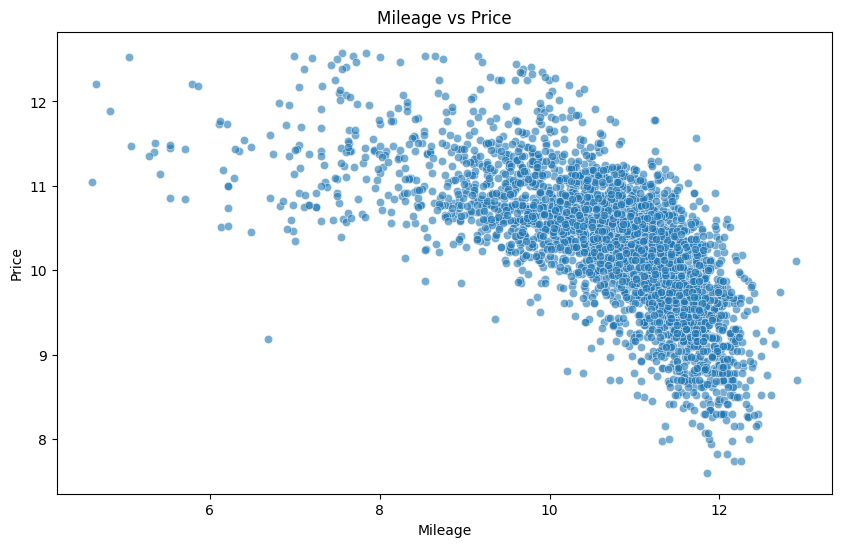

In [13]:
# Show relationship between mileage and price without log transformation
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_train_original['milage'], y=y_train_original, alpha=0.6)
plt.xlabel('Mileage')
plt.ylabel('Price')
plt.title('Mileage vs Price')
plt.show()

[##############################] 100% (2/2) | Elapsed: 0.04s | ETA: 0.00s / LR - Original 

Best hyperparameters: {'fit_intercept': True} with:
	Mean RMSE: 27339.9719
	Mean MSE: 748992481.9712
	Mean MAE: 13620.4833
	Mean MAPE: 35.2042
	Mean R²: 0.4427
	Mean Adjusted R²: 0.4356
	Mean PCC: 0.7212


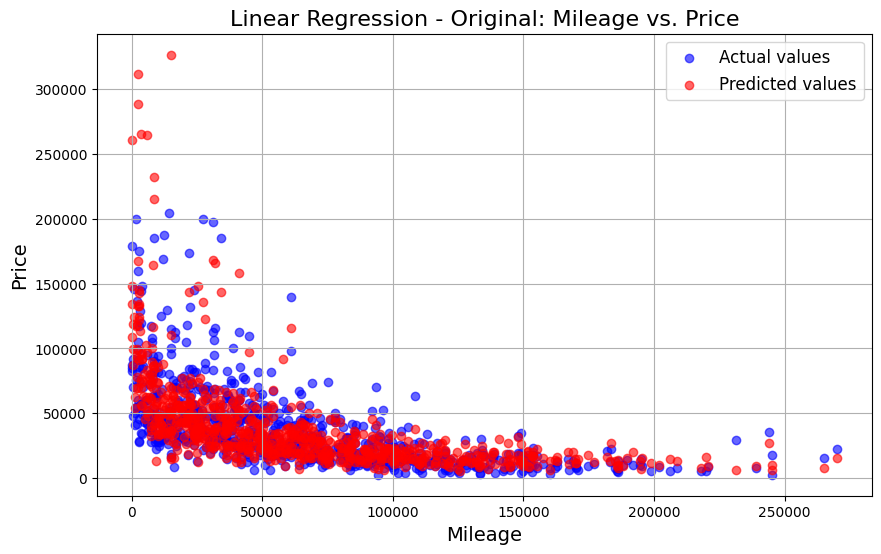

[##############################] 100% (2/2) | Elapsed: 0.27s | ETA: 0.00s / LR - Mixed 

Best hyperparameters: {'fit_intercept': True} with:
	Mean RMSE: 16681.9868
	Mean MSE: 278326318.5758
	Mean MAE: 10900.1546
	Mean MAPE: 40.8981
	Mean R²: 0.4852
	Mean Adjusted R²: 0.4850
	Mean PCC: 0.7138


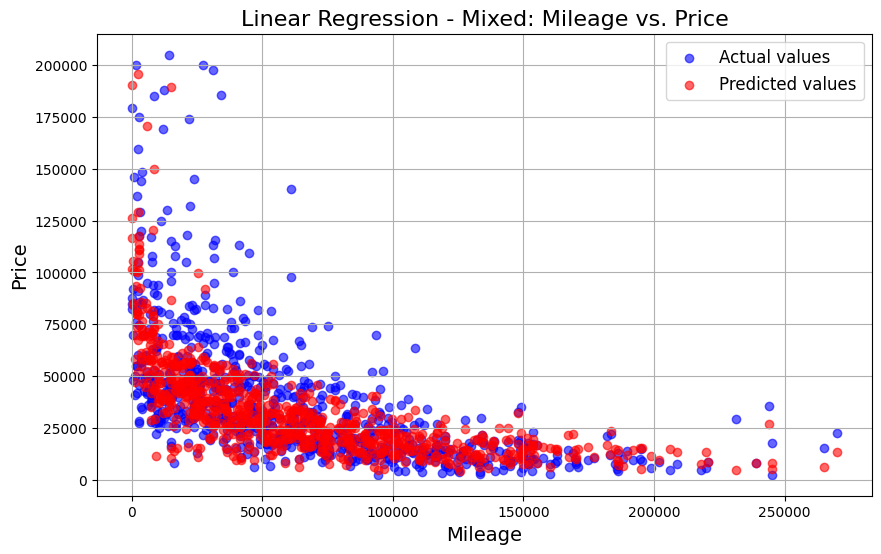

In [14]:
param_grid = {
    'fit_intercept': [True, False]
}

#################
# Original data #
#################

best_result_linear_original, all_results_linear_original = hyperparameter_tuning_with_cv(X_train_original, y_train_original, param_grid, verbose=False, name="LR - Original")
best_params_linear_original = best_result_linear_original['params']
scaler = RobustScaler()

X_train_lr_original = X_train_original.copy()
y_train_lr_original = y_train_original.copy()
X_test_lr_original = X_test.copy()

X_train_scaled_original = scaler.fit_transform(X_train_lr_original)
X_test_scaled_original = scaler.transform(X_test_lr_original)

final_linear_model_original = LinearRegression(**best_params_linear_original)
final_linear_model_original.fit(X_train_scaled_original, y_train_lr_original)

# Generate predictions for evaluation
y_pred_linear_original = final_linear_model_original.predict(X_test_scaled_original)

y_test_exp = np.expm1(y_test)
y_pred_linear_original_exp = np.expm1(y_pred_linear_original)
Milage_exp = np.expm1(X_test['milage'])
plot_mileage_vs_price(
    mileage=Milage_exp,
    actual_price=y_test_exp,
    predicted_price=y_pred_linear_original_exp,
    model_name="Linear Regression - Original"
)

#################
#   Mixed data  #
#################

best_result_linear_mixed, all_results_linear_mixed = hyperparameter_tuning_with_cv(X_train_mixed, y_train_mixed, param_grid, verbose=False, name="LR - Mixed")
best_params_linear_mixed = best_result_linear_mixed['params']
scaler = RobustScaler()

X_train_lr_mixed = X_train_mixed.copy()
y_train_lr_mixed = y_train_mixed.copy()
X_test_lr_mixed = X_test.copy()

X_train_scaled_mixed = scaler.fit_transform(X_train_lr_mixed)
X_test_scaled_mixed = scaler.transform(X_test_lr_mixed)

final_linear_model_mixed = LinearRegression(**best_params_linear_mixed)
final_linear_model_mixed.fit(X_train_scaled_mixed, y_train_lr_mixed)

# Generate predictions for evaluation
y_pred_linear_mixed = final_linear_model_mixed.predict(X_test_scaled_mixed)

y_test_exp = np.expm1(y_test)
y_pred_linear_mixed_exp = np.expm1(y_pred_linear_mixed)
Milage_exp = np.expm1(X_test['milage'])

plot_mileage_vs_price(
    mileage=Milage_exp,
    actual_price=y_test_exp,
    predicted_price=y_pred_linear_mixed_exp,
    model_name="Linear Regression - Mixed"
)

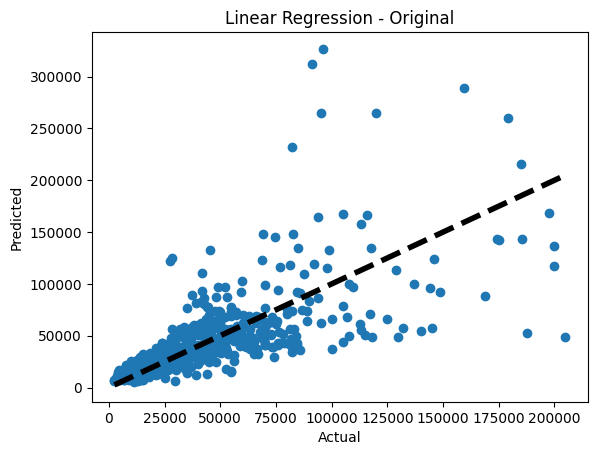

In [15]:
pred_vs_actual_linear_original = pd.DataFrame({
    'Actual': y_test_exp,
    'Predicted': y_pred_linear_original_exp
})



plot_actual_vs_predicted(pred_vs_actual_linear_original['Actual'], pred_vs_actual_linear_original['Predicted'], "Linear Regression - Original")

In [16]:
# 

[##############################] 100% (2/2) | Elapsed: 0.10s | ETA: 0.00s / LR - Poly - Original 

Best hyperparameters: {'fit_intercept': True} with:
	Mean RMSE: 39581.5340
	Mean MSE: 2911658537.3624
	Mean MAE: 12206.8182
	Mean MAPE: 30.5871
	Mean R²: -1.4190
	Mean Adjusted R²: -1.4499
	Mean PCC: 0.7138


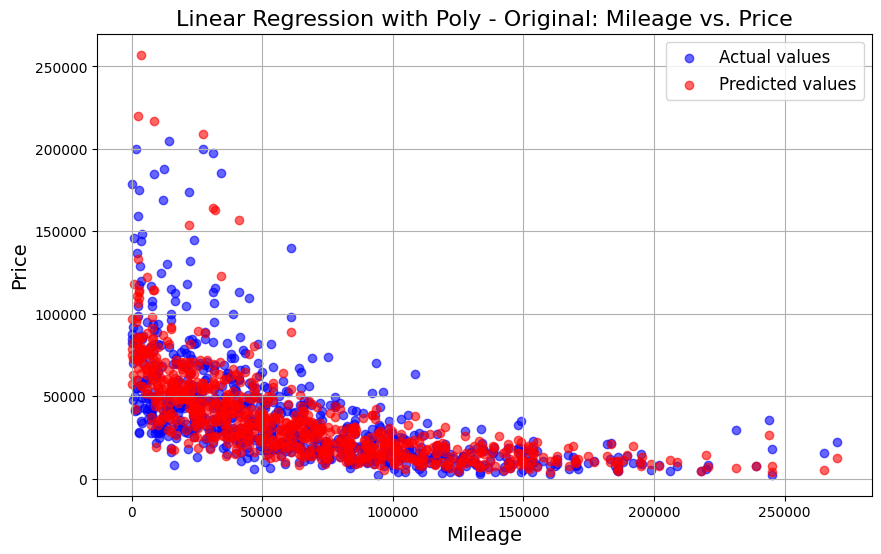

[##############################] 100% (2/2) | Elapsed: 2.06s | ETA: 0.00s / LR - Poly - Mixed 

Best hyperparameters: {'fit_intercept': True} with:
	Mean RMSE: 173136534.4744
	Mean MSE: 149859243048701248.0000
	Mean MAE: 1235776.4145
	Mean MAPE: 1019.0041
	Mean R²: -274763339.7875
	Mean Adjusted R²: -274873531.6226
	Mean PCC: 0.5959


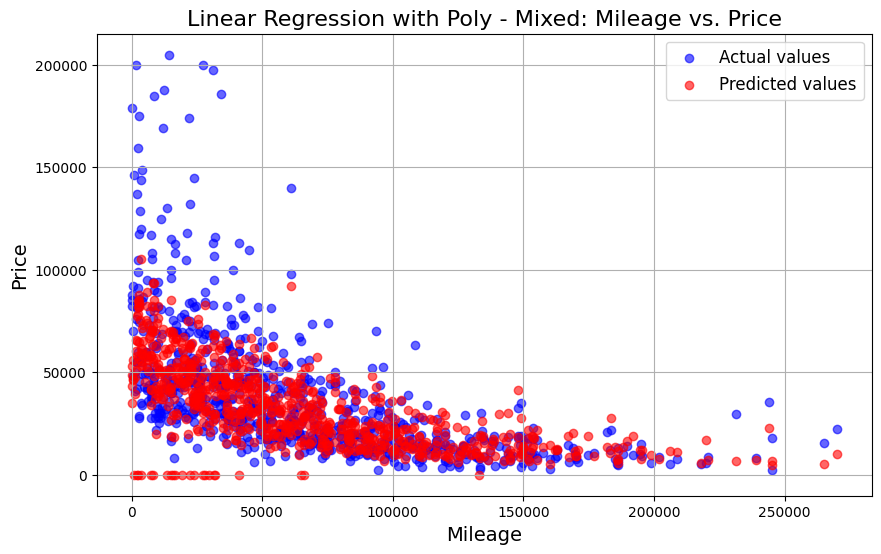

In [17]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

param_grid = {
    'fit_intercept': [True, False]
}

#################
# Original data #
#################

best_result_poly_original, all_results_poly_original = hyperparameter_tuning_with_cv(X_train_original, y_train_original, param_grid, polynomial=True, verbose=False, name="LR - Poly - Original")
best_params_poly_original = best_result_poly_original['params']

scaler = RobustScaler()
poly = PolynomialFeatures(degree=2, include_bias=False)

X_train_poly_original = X_train_original.copy()
y_train_poly_original = y_train_original.copy()
X_test_poly_original = X_test.copy()

# Apply polynomial feature transformation
X_train_tf_poly_original = poly.fit_transform(X_train_poly_original)
X_test_tf_poly_original = poly.transform(X_test_poly_original)

# Scale the polynomial features
X_train_tf_scaled_poly_original = scaler.fit_transform(X_train_tf_poly_original)
X_test_tf_scaled_poly_original = scaler.transform(X_test_tf_poly_original)

final_model_poly_original = LinearRegression(**best_params_poly_original)
final_model_poly_original.fit(X_train_tf_scaled_poly_original, y_train_poly_original)

# Generate predictions for evaluation
y_pred_poly_original = final_model_poly_original.predict(X_test_tf_scaled_poly_original)

y_test_exp = np.expm1(y_test)
y_pred_poly_original_exp = np.expm1(y_pred_poly_original)
Milage_exp = np.expm1(X_test['milage'])

plot_mileage_vs_price(
    mileage=Milage_exp,
    actual_price=y_test_exp,
    predicted_price=y_pred_poly_original_exp,
    model_name="Linear Regression with Poly - Original"
)

#################
#   Mixed data  #
#################

best_result_poly_mixed, all_results_poly_mixed = hyperparameter_tuning_with_cv(X_train_mixed, y_train_mixed, param_grid, polynomial=True, verbose=False, name="LR - Poly - Mixed")
best_params_poly_mixed = best_result_poly_mixed['params']
scaler = RobustScaler()

X_train_poly_mixed = X_train_mixed.copy()
y_train_poly_mixed = y_train_mixed.copy()
X_test_poly_mixed = X_test.copy()

# Apply polynomial feature transformation
X_train_tf_poly_mixed = poly.fit_transform(X_train_poly_mixed)
X_test_tf_poly_mixed = poly.transform(X_test_poly_mixed)

# Scale the polynomial features
X_train_tf_scaled_poly_mixed = scaler.fit_transform(X_train_tf_poly_mixed)
X_test_tf_scaled_poly_mixed = scaler.transform(X_test_tf_poly_mixed)

final_model_poly_mixed = LinearRegression(**best_params_poly_mixed)
final_model_poly_mixed.fit(X_train_tf_scaled_poly_mixed, y_train_poly_mixed)

# Generate predictions for evaluation
y_pred_poly_mixed = final_model_poly_mixed.predict(X_test_tf_scaled_poly_mixed)

y_test_exp = np.expm1(y_test)
y_pred_poly_mixed_exp = np.expm1(y_pred_poly_mixed)
Milage_exp = np.expm1(X_test['milage'])

plot_mileage_vs_price(
    mileage=Milage_exp,
    actual_price=y_test_exp,
    predicted_price=y_pred_poly_mixed_exp,
    model_name="Linear Regression with Poly - Mixed"
)

#### Random Forest Regression

[##############################] 100% (324/324) | Elapsed: 89.03s | ETA: 0.00s / Linear Regression 

Best hyperparameters: {'n_estimators': 50, 'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2'} with:
	Mean RMSE: 20994.4945
	Mean MSE: 442947676.0080
	Mean MAE: 11070.3506
	Mean MAPE: 28.9576
	Mean R²: 0.6715
	Mean Adjusted R²: 0.6673
	Mean PCC: 0.8310


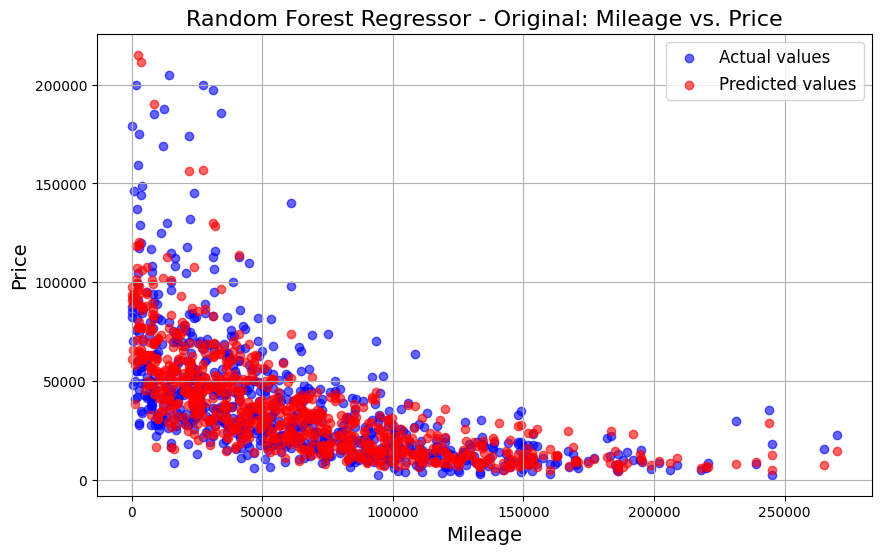

[##############################] 100% (324/324) | Elapsed: 2109.68s | ETA: 0.00s / Linear Regression  

Best hyperparameters: {'n_estimators': 50, 'max_depth': 20, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'log2'} with:
	Mean RMSE: 14803.2802
	Mean MSE: 219175710.4407
	Mean MAE: 9744.2515
	Mean MAPE: 36.5017
	Mean R²: 0.5946
	Mean Adjusted R²: 0.5944
	Mean PCC: 0.7792


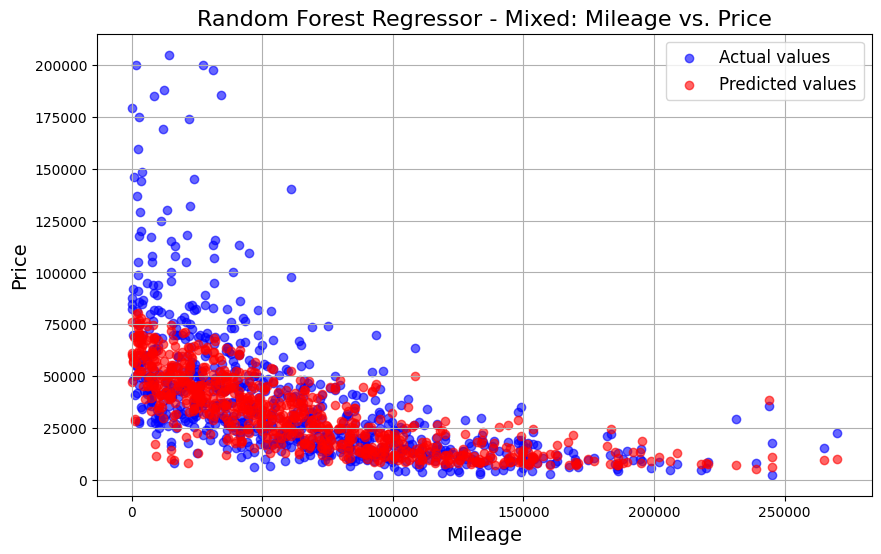

In [18]:
from sklearn.ensemble import RandomForestRegressor

param_grid = {
    'n_estimators': [10, 25, 50],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2'],
}

#################
# Original data #
#################

best_result_rfr_original, all_results_rfr_original = hyperparameter_tuning_with_cv(X=X_train_original, y=y_train_original, param_grid=param_grid, model_class=RandomForestRegressor, verbose=False)
best_params_rfr_original = best_result_rfr_original['params']
scaler = RobustScaler()

X_train_rfr_original = X_train_original.copy()
y_train_rfr_original = y_train_original.copy()
X_test_rfr_original = X_test.copy()

X_train_scaled_rfr_original = scaler.fit_transform(X_train_rfr_original)
X_test_scaled_rfr_original = scaler.transform(X_test_rfr_original)

final_model_rfr_original = RandomForestRegressor(**best_params_rfr_original)
final_model_rfr_original.fit(X_train_scaled_rfr_original, y_train_rfr_original)

# Generate predictions for evaluation
y_pred_rfr_original = final_model_rfr_original.predict(X_test_scaled_rfr_original)
y_pred_rfr_original_exp = np.expm1(y_pred_rfr_original)
y_test_exp = np.expm1(y_test)
Milage_exp = np.expm1(X_test['milage'])
plot_mileage_vs_price(
    mileage=Milage_exp,
    actual_price=y_test_exp,
    predicted_price=y_pred_rfr_original_exp,
    model_name="Random Forest Regressor - Original"
)

#################
#   Mixed data  #
#################

best_result_rfr_mixed, all_results_rfr_mixed = hyperparameter_tuning_with_cv(X=X_train_mixed, y=y_train_mixed, param_grid=param_grid, model_class=RandomForestRegressor, verbose=False)
best_params_rfr_mixed = best_result_rfr_mixed['params']
scaler = RobustScaler()

X_train_rfr_mixed = X_train_mixed.copy()
y_train_rfr_mixed = y_train_mixed.copy()
X_test_rfr_mixed = X_test.copy()

X_train_rfr_scaled_mixed = scaler.fit_transform(X_train_rfr_mixed)
X_test_rfr_scaled_mixed = scaler.transform(X_test_rfr_mixed)

final_model_rfr_mixed = RandomForestRegressor(**best_params_rfr_mixed)
final_model_rfr_mixed.fit(X_train_rfr_scaled_mixed, y_train_rfr_mixed)

# Generate predictions for evaluation
y_pred_rfr_mixed = final_model_rfr_mixed.predict(X_test_rfr_scaled_mixed)
y_pred_rfr_mixed_exp = np.expm1(y_pred_rfr_mixed)
y_test_exp = np.expm1(y_test)
Milage_exp = np.expm1(X_test['milage'])
plot_mileage_vs_price(
    mileage=Milage_exp,
    actual_price=y_test_exp,
    predicted_price=y_pred_rfr_mixed_exp,
    model_name="Random Forest Regressor - Mixed"
)

#### XGBoost

[##############################] 100% (60/60) | Elapsed: 45.60s | ETA: 0.00s / XGBoost - Original 

Best hyperparameters: {'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.8, 'min_child_weight': 3} with:
	Mean RMSE: 20838.0436
	Mean MSE: 436755092.5569
	Mean MAE: 10940.8265
	Mean MAPE: 28.6881
	Mean R²: 0.6772
	Mean Adjusted R²: 0.6731
	Mean PCC: 0.8277


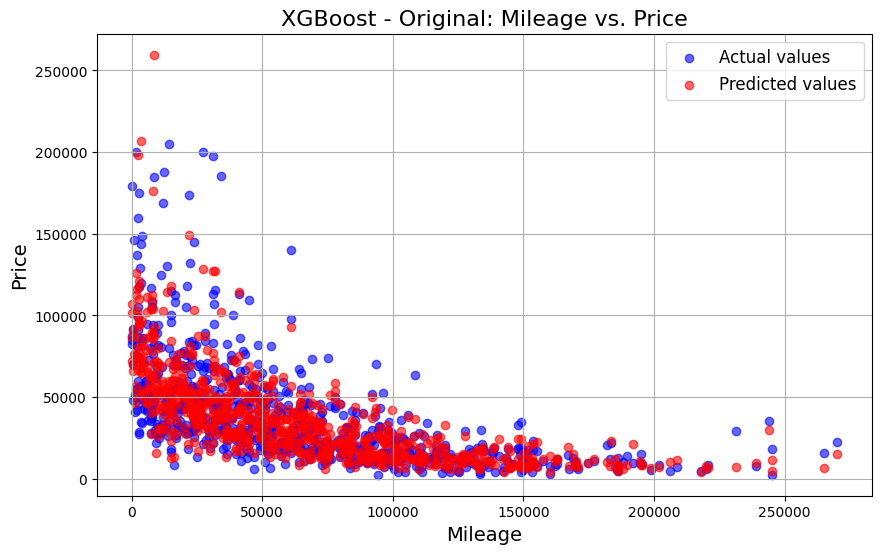

[##############################] 100% (60/60) | Elapsed: 81.23s | ETA: 0.00s / XGBoost - Mixed 

Best hyperparameters: {'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.8, 'min_child_weight': 1} with:
	Mean RMSE: 14691.0631
	Mean MSE: 215866058.8497
	Mean MAE: 9669.7551
	Mean MAPE: 36.2318
	Mean R²: 0.6007
	Mean Adjusted R²: 0.6006
	Mean PCC: 0.7827


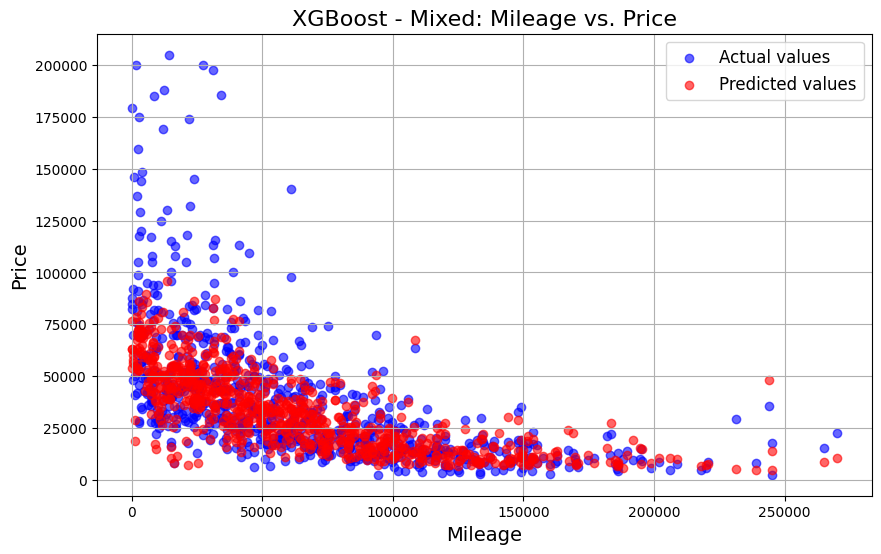

In [19]:
from xgboost import XGBRegressor

param_grid = {
    'n_estimators': [10, 25, 50, 100, 200],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.1, 0.3],
    'subsample': [0.8],
    'colsample_bytree': [0.8],
    'min_child_weight': [1, 3]
}

#################
# Original data #
#################

best_result_xg_original, all_results_xg_original = hyperparameter_tuning_with_cv(
    X=X_train_original, y=y_train_original, param_grid=param_grid, model_class=XGBRegressor,
    verbose=False, name="XGBoost - Original"
)
best_params_xg_original = best_result_xg_original['params']
scaler = RobustScaler()

X_train_xg_original = X_train_original.copy()
y_train_xg_original = y_train_original.copy()
X_test_xg_original = X_test.copy()

X_train_xg_scaled_original = scaler.fit_transform(X_train_xg_original)
X_test_xg_scaled_original = scaler.transform(X_test_xg_original)

final_model_xg_original = XGBRegressor(**best_params_xg_original)
final_model_xg_original.fit(X_train_xg_scaled_original, y_train_xg_original)

# Generate predictions for evaluation
y_pred_xg_original = final_model_xg_original.predict(X_test_xg_scaled_original)

y_pred_xg_original_exp = np.expm1(y_pred_xg_original)
y_test_exp = np.expm1(y_test)
Milage_exp = np.expm1(X_test['milage'])

plot_mileage_vs_price(
    mileage=Milage_exp,
    actual_price=y_test_exp,
    predicted_price=y_pred_xg_original_exp,
    model_name="XGBoost - Original"
)

#################
#   Mixed data  #
#################

best_result_xg_mixed, all_results_xg_mixed = hyperparameter_tuning_with_cv(
    X=X_train_mixed, y=y_train_mixed, param_grid=param_grid,
    model_class=XGBRegressor, verbose=False, name="XGBoost - Mixed"
)
best_params_xg_mixed = best_result_xg_mixed['params']
scaler = RobustScaler()

X_train_xg_mixed = X_train_mixed.copy()
y_train_xg_mixed = y_train_mixed.copy()
X_test_xg_mixed = X_test.copy()

X_train_xg_scaled_mixed = scaler.fit_transform(X_train_xg_mixed)
X_test_xg_scaled_mixed = scaler.transform(X_test_xg_mixed)

final_model_xg_mixed = XGBRegressor(**best_params_xg_mixed)
final_model_xg_mixed.fit(X_train_xg_scaled_mixed, y_train_xg_mixed)

# Generate predictions for evaluation
y_pred_xg_mixed = final_model_xg_mixed.predict(X_test_xg_scaled_mixed)
y_pred_xg_mixed_exp = np.expm1(y_pred_xg_mixed)
y_test_exp = np.expm1(y_test)
plot_mileage_vs_price(
    mileage=Milage_exp,
    actual_price=y_test_exp,
    predicted_price=y_pred_xg_mixed_exp,
    model_name="XGBoost - Mixed"
)

In [20]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold

# Initialize the XGBoost regressor
model = XGBRegressor(objective='reg:squarederror', random_state=42)

def training_XGBoost(initial_model, y, X):
    # Cross-validation loop
    mse_scores = []                     # Store MSE for each fold
    r2_scores = []                      # Store R² for each fold
    adjusted_r2_scores = []             # Store Adjusted R² for each fold
    mean_absolute_percentage_error = [] # Store MAPE for each fold
    mae_scores = []                     # Store MAE for each fold
    model_list = []                     # Store the models for each fold

    n = len(train_dataset_original)  # Total number of samples
    p = X.shape[1]    # Number of predictors
    i = 1

    x_copy = X.copy()
    y_copy = y.copy()

    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    for train_index, val_index in kf.split(X):
        # Split the data
        X_train_fold, X_val_fold = x_copy.iloc[train_index], x_copy.iloc[val_index]
        y_train_fold, y_val_fold = y_copy.iloc[train_index], y_copy.iloc[val_index]

        # Make sure the model is reinitialized for each fold
        model = None
        model = initial_model

        # Train the model
        model.fit(X_train_fold, y_train_fold)

        # Predict on the test fold
        y_pred = model.predict(X_val_fold)

        # Calculate metrics
        mse, rmse, mae, mape, r2, adjusted_r2, pcc = calculate_metrics(y_val_fold, y_pred)

        # Store metrics
        mse_scores.append(mse)
        r2_scores.append(r2)
        adjusted_r2_scores.append(adjusted_r2)
        mean_absolute_percentage_error.append(mape)
        mae_scores.append(mae)
        
        print(f"Run {i}:\nMSE: {mse}\nRMSE: {np.sqrt(mse)}\nR2: {r2}\nAdjusted R2: {adjusted_r2}\n")
        i = i + 1

        # Store the model
        model_list.append(model)

    dict_of_results = {
        'mse': mse_scores,
        'r2': r2_scores,
        'adjusted_r2': adjusted_r2_scores,
        'mape': mean_absolute_percentage_error,
        'mae': mae_scores,
        'model': model_list
    }

    return dict_of_results


initial_model = XGBRegressor(objective='reg:squarederror', random_state=42)
results = training_XGBoost(initial_model, y_train_original, X_train_original)


mse_scores = results['mse']
r2_scores = results['r2']
adjusted_r2_scores = results['adjusted_r2']
mean_absolute_percentage_error = results['mape']
mae_scores = results['mae']

# Average metrics across folds
avg_mse = sum(mse_scores) / len(mse_scores)
avg_r2 = sum(r2_scores) / len(r2_scores)
avg_adjusted_r2 = sum(adjusted_r2_scores) / len(adjusted_r2_scores)
avg_mape = sum(mean_absolute_percentage_error) / len(mean_absolute_percentage_error)
avg_mae = sum(mae_scores) / len(mae_scores)

print(f"Average MSE: {avg_mse:.2f}")
print(f"Average R²: {avg_r2:.2f}")
print(f"Average Adjusted R²: {avg_adjusted_r2:.2f}")
print(f"Average MAPE: {avg_mape:.2f}")
print(f"Average MAE: {avg_mae:.2f}")


Run 1:
MSE: 453353288.90037376
RMSE: 21292.09451651889
R2: 0.6427766541842206
Adjusted R2: 0.6382260383139559

Run 2:
MSE: 409300625.62828845
RMSE: 20231.17954120047
R2: 0.7003768521182072
Adjusted R2: 0.696559996731178

Run 3:
MSE: 431147625.0795465
RMSE: 20764.094612564895
R2: 0.67824736589771
Adjusted R2: 0.6741486062276171

Run 4:
MSE: 539247999.2676433
RMSE: 23221.713960593937
R2: 0.6661891558785723
Adjusted R2: 0.6619300063523021

Run 5:
MSE: 444907927.52358145
RMSE: 21092.84066984771
R2: 0.6226190170589061
Adjusted R2: 0.6178039486960214

Average MSE: 455591493.28
Average R²: 0.66
Average Adjusted R²: 0.66
Average MAPE: 29.90
Average MAE: 11150.50


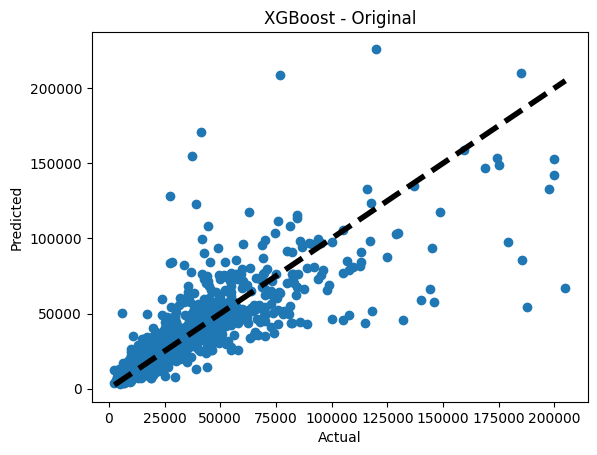

In [21]:
model_for_testing = results['model'][2]

y_pred = model_for_testing.predict(X_test)
y_pred_exp = np.expm1(y_pred)
y_test_exp = np.expm1(y_test)

plot_actual_vs_predicted(y_test_exp, y_pred_exp, "XGBoost - Original")

In [22]:
model_for_testing = XGBRegressor(objective='reg:squarederror', random_state=42)
model_for_testing.fit(X_train_original, y_train_original)


# Predict on the test set
y_pred = model_for_testing.predict(X_test)


calculate_metrics(y_test, y_pred)

(np.float64(441546402.7163939),
 np.float64(21013.00556123264),
 np.float64(11598.424303703501),
 np.float64(33.32724508327888),
 np.float64(0.5745090340334897),
 np.float64(0.5701394220595076),
 np.float64(0.7682709663613815))